# Further reading

For tips and tricks on training GANs in general, see Soumith Chintala's [ganhacks write-up](https://github.com/soumith/ganhacks).

# GAN Workshop Exercise:

<b>In this exercise we will build a very simple Generative Adversarial Network (GAN) from scratch to generate handwritten digits in the same style as MNIST.

Note:
* This exercise assumes TF2. The final training will run much faster on GPU (you could use Google Colab for this).
* Use the value for `RANDOM_DIM` given below (dimension of the [latent space](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/) of noise input to model)</b>



In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.keras.backend.clear_session()  # For easy reset of notebook state.
from keras.datasets.mnist import load_data
from keras.layers import LeakyReLU
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt


Using TensorFlow backend.


**sourse link:**<br>https://www.tensorflow.org/tutorials/generative/dcgan<br>https://keras.io/examples/mnist_acgan/<br>https://www.machinecurve.com/index.php/2019/11/12/using-leaky-relu-with-keras/<br>

# Questions:
### 1.  Load the MNIST dataset from `tensorflow.keras.datasets` and save the training images in `X_train`, normalizing the pixel values to the range $[-1, 1]$.


In [2]:
# load the images into memory
(X_train, y_train), (X_test, y_test) = load_data()

# summarize the shape of the dataset
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

11493376/11490434 [==============================] - 2s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [0]:
X_train=X_train.astype('float32')/255.0
X_train=(2.0*X_train)-1

### 2. Reshape X_train using `.reshape(-1, ...)` so that each image is a vector of length 28*28=784.


In [4]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_train.shape

(60000, 784)

### 3. Define `lrelu = LeakyReLU(0.2)`, using the leaky ReLU activation function from `tensorflow.keras.layers`.


In [0]:
lrelu = activation=tf.keras.layers.LeakyReLU(0.2)

### 4. **Creating the generator model:** 
* <b>Define `generator` to be a Keras Sequential model with four fully-connected (Dense) layers of sizes 256, 512, 1024, and 784, and with `input_dim=RANDOM_DIM`. 
* Use `lrelu` as the activation function for the first three layers and `tanh` as the activation function for the last layer. 

**Hint**: `generator` should have input shape `(None, RANDOM_DIM)`, output shape `(None, 784)`, and 1,463,312 parameters. (`generator.count_params()`)</b>


In [0]:
RANDOM_DIM = 10

In [7]:
generator = Sequential([
        
        Dense(256,input_dim=RANDOM_DIM, activation = lrelu, name='layer1'),
        Dense(512,input_dim=RANDOM_DIM, activation=lrelu, name="layer2"),
        Dense(1024,input_dim=RANDOM_DIM, activation=lrelu, name="layer3"),
        Dense(784,input_dim=RANDOM_DIM, activation='tanh', name="layer4")
    ])
generator.input_shape, generator.output_shape

((None, 10), (None, 784))

In [8]:
generator.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 256)               2816      
_________________________________________________________________
layer2 (Dense)               (None, 512)               131584    
_________________________________________________________________
layer3 (Dense)               (None, 1024)              525312    
_________________________________________________________________
layer4 (Dense)               (None, 784)               803600    
Total params: 1,463,312
Trainable params: 1,463,312
Non-trainable params: 0
_________________________________________________________________


### 5. **Creating the discriminator model:** 
- <b>Define `discriminator` to be a Keras Sequential model with `input_dim=784`. 
- Use four fully-connected (Dense) layers of sizes 1024, 512, 256, and 1, and layer `Dropout(0.3)` (a [dropout layer](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) with dropout probability 0.3) in between every pair of Dense layers (so three dropout layers total). 
- Use `lrelu` as the activation function for the first three layers and `sigmoid` as the activation function for the last layer. 

**Hint:** `discriminator` should have input shape `(None, 784)`, output shape `(None, 1)`, and 1,460,225 parameters.</b>


In [9]:
discriminator = Sequential([
        
        Dense(1024,input_dim=784, activation = lrelu, name='layer1'),
        Dropout(0.3),
        Dense(512,input_dim=784, activation=lrelu, name="layer2"),
        Dropout(0.3),
        Dense(256,input_dim=784, activation=lrelu, name="layer3"),
        Dropout(0.3),
        Dense(1,input_dim=784, activation='sigmoid', name="layer4")
    ])
discriminator.input_shape, discriminator.output_shape

((None, 784), (None, 1))

In [10]:
discriminator.summary();

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 1024)              803840    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
layer2 (Dense)               (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
layer3 (Dense)               (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
layer4 (Dense)               (None, 1)                

### 6. **Creating the GAN model:** Define `gan = Sequential([generator, discriminator])`.


In [0]:
gan = Sequential([generator, discriminator])

 ### What are the input and output shapes of this model? 

In [12]:
gan.input_shape, gan.output_shape

((None, 10), (None, 1))

### How many parameters does it have?

In [13]:
gan.summary();

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 784)               1463312   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 2,923,537
Non-trainable params: 0
_________________________________________________________________


### 7. Run the code in the cell below to compile these models using the Adam optimizer with custom parameters. **Note:** You **must** set `discriminator.trainable = False` only after compiling the `discriminator` model. This is because the weights of the discriminator can update when the discriminator is trained, but not when the generator is trained.


In [0]:
##### RUN THIS CODE FOR QUESTION 7 #####
from tensorflow.keras.optimizers import Adam

custom_adam = Adam(lr=0.0002, beta_1=0.5)
generator.compile(loss='binary_crossentropy', optimizer=custom_adam)
discriminator.compile(loss='binary_crossentropy', optimizer=custom_adam)
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=custom_adam)

### 8. Create a function `get_input_noise` which takes a parameter `n_examples` and returns a vector of random noise (sampled from `np.random.normal(0, 1, ...)` ) with output of shape `(n_examples, RANDOM_DIM)`.


In [18]:
def get_input_noise(n_examples):
    noise = np.random.normal(0, 1, (n_examples,RANDOM_DIM))
    return noise


#shape check
(get_input_noise(100)).shape

(100, 10)

### 9. Run the code in the cell below to use `get_input_noise(...)` as the input to the `generator` model to generate images, and plot them with the given `plot_generated_images(...)` function. What do the generated images look like before the GAN is trained?


In [0]:
##### USE THIS CODE FOR QUESTION 9 #####

def generate_images(n_examples):
    return generator.predict(get_input_noise(n_examples))

def plot_generated_images(n_examples=100):
    generated_images = generate_images(n_examples).reshape(-1, 28, 28)
    plt.figure(figsize=(10, 10))
    for i in range(generated_images.shape[0]):
        plt.subplot(10, 10, i + 1)
        plt.imshow(generated_images[i], cmap='gray_r')
        plt.axis('off');


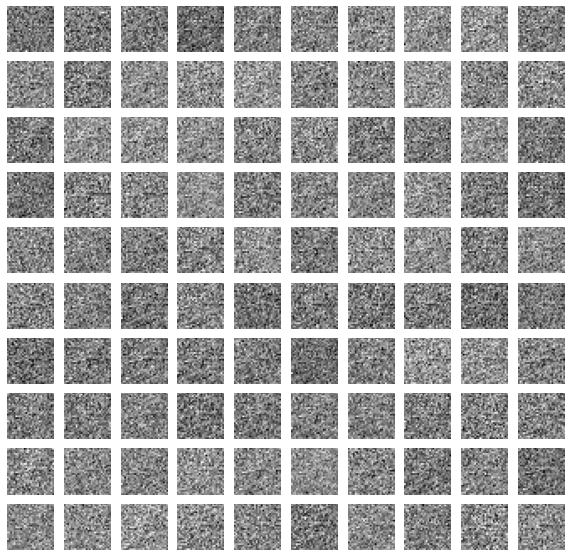

In [19]:
plot_generated_images()

### 10. Explain in words what each function does in the code below marked "USE THIS CODE FOR QUESTION 10".


In [0]:
##### USE THIS CODE FOR QUESTION 10 ####
def get_random_image_batch(batchsize):
    """The function gets int bach size
    returns a matrix X_train (with real image vectors) 
    of shape (batchsize, 784)
    """
    return X_train[np.random.randint(0, X_train.shape[0], size=batchsize)]

def train_discriminator(batchsize):
    """The function gets int batch size
    generates real images + fake images
    generates labels  and put it all 
    into discriminator model  to train on batches
    """
    image_batch = get_random_image_batch(batchsize)
    generated_images = generate_images(batchsize)
    X = np.concatenate([image_batch, generated_images])
    disc_labels = np.concatenate((np.ones(batchsize), np.zeros(batchsize)))
    discriminator.train_on_batch(X, disc_labels)

def train_generator(batchsize):
  """ The function generates noise and labels;
  and put it all into gan model to train on batches
  """
    noise = get_input_noise(batchsize)
    gen_labels = np.ones(batchsize)
    gan.train_on_batch(noise, gen_labels)

def train_gan(batchsize):
  """The function calls train_discriminator
  and  train_generator functions
  """
    train_discriminator(batchsize)
    train_generator(batchsize)

### 11. Run the code below to train the GAN, outputting generated images every 10 epochs.


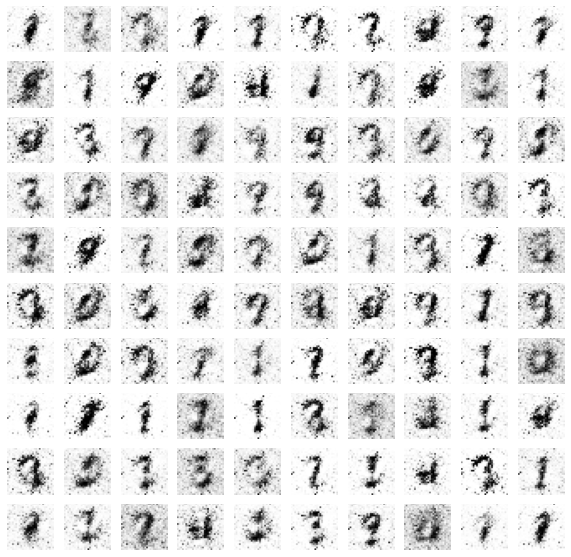

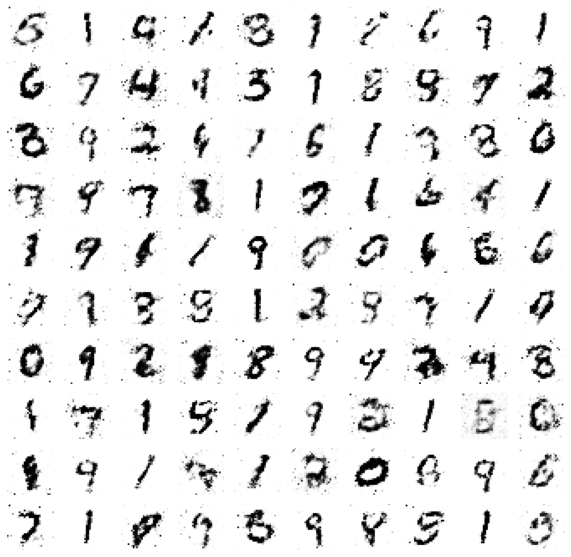

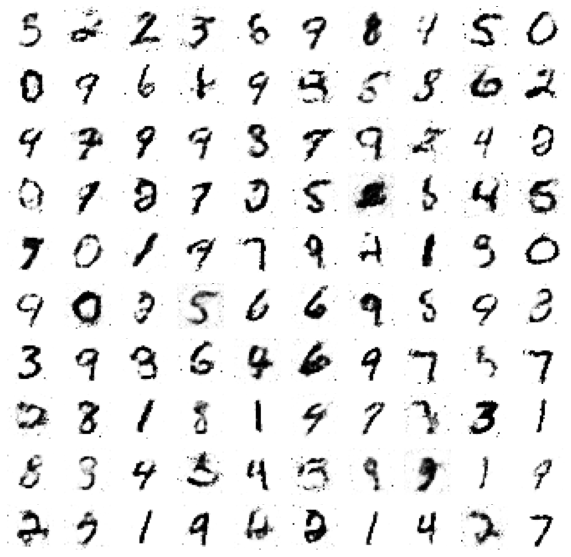

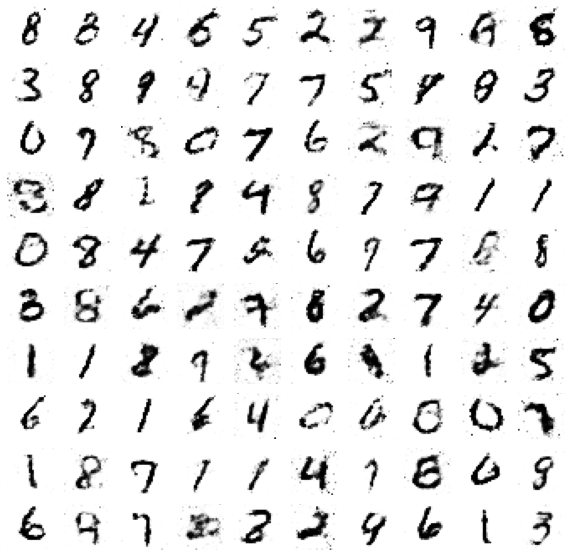

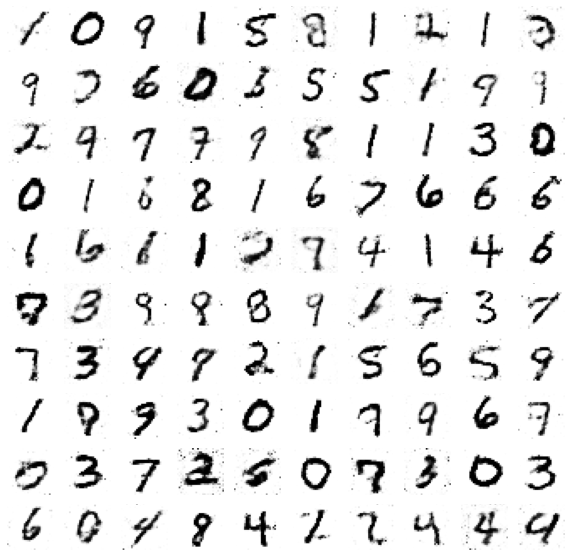

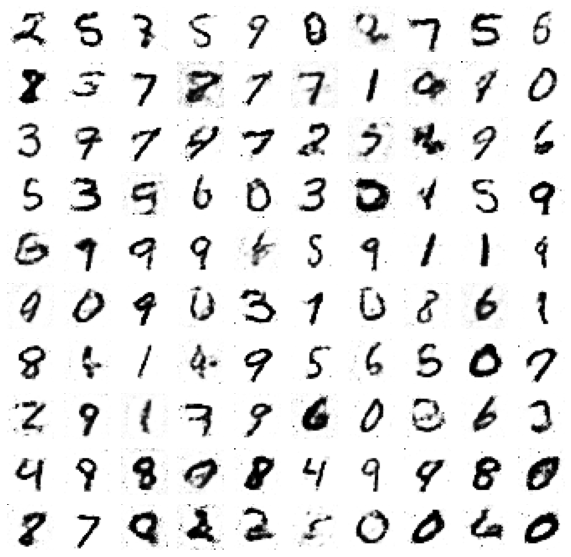

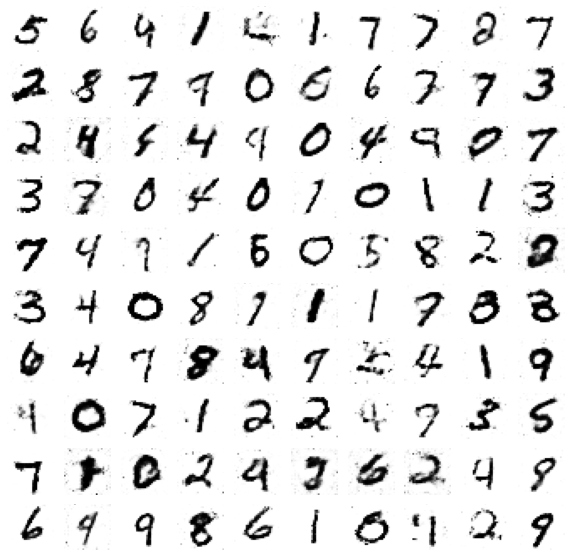

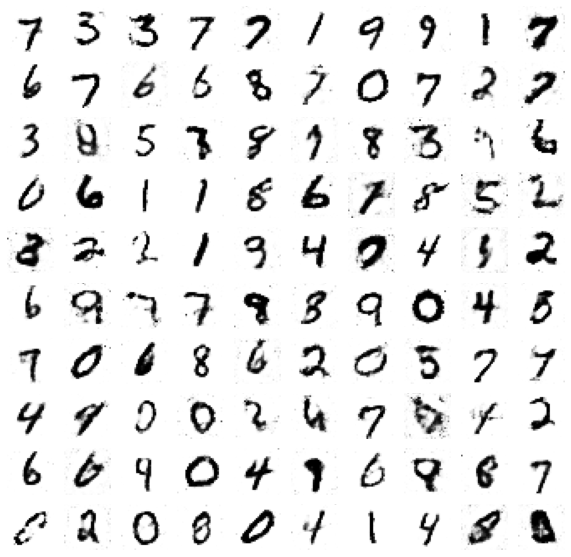

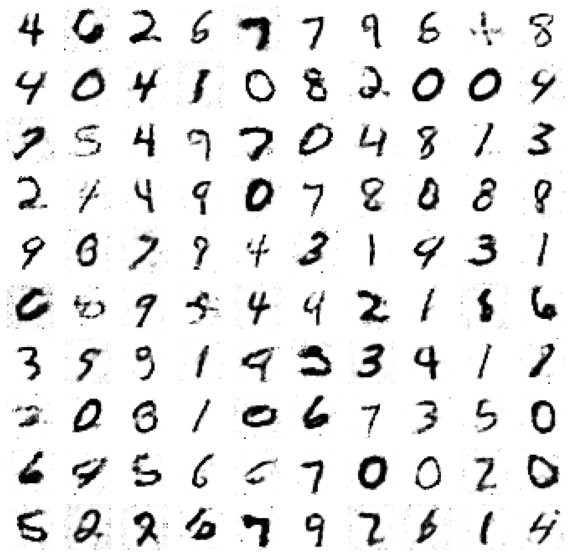

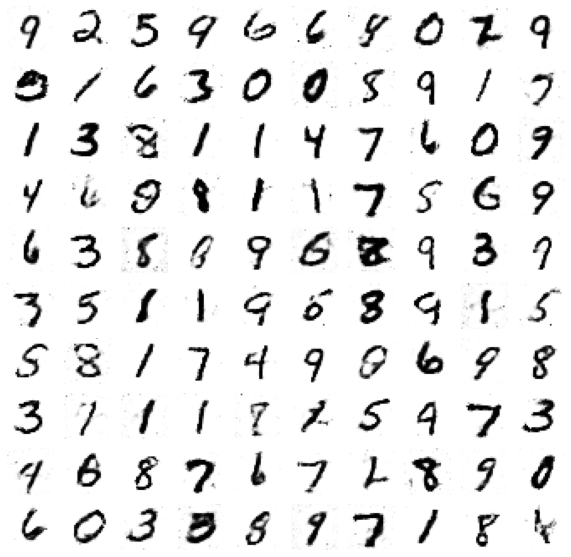

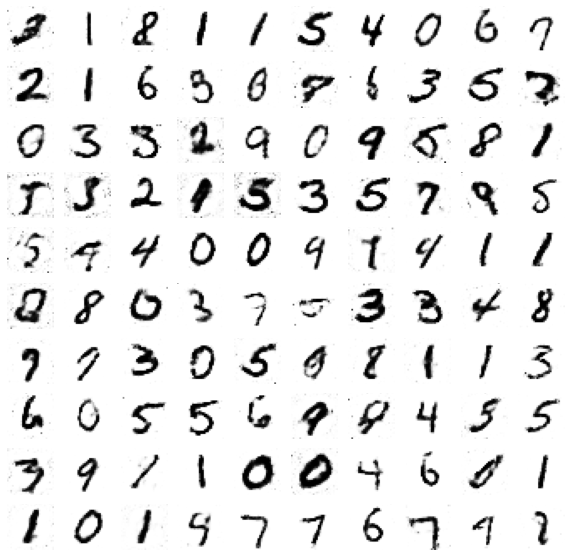

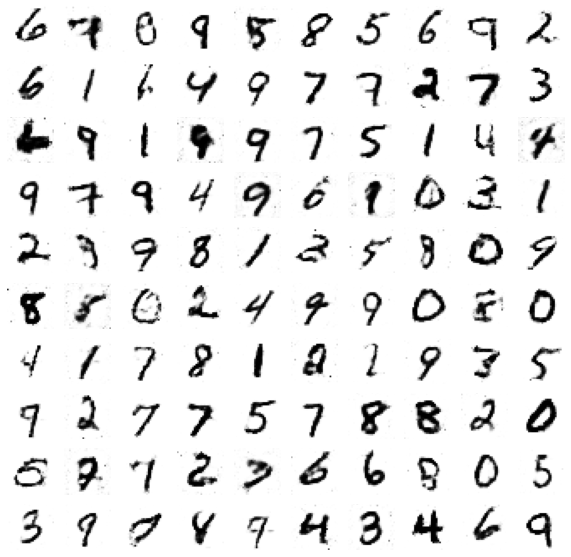

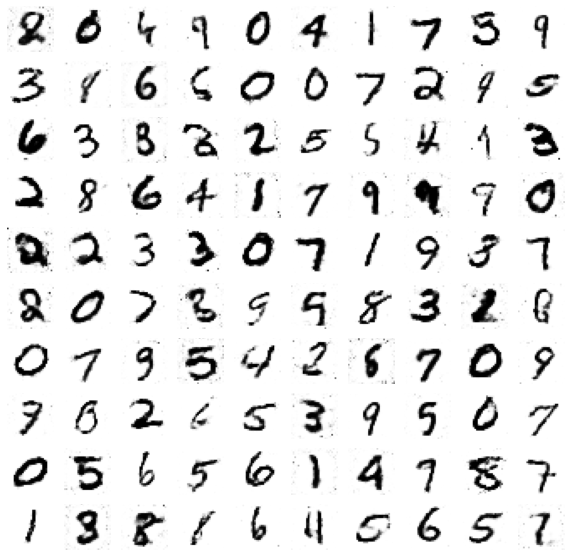

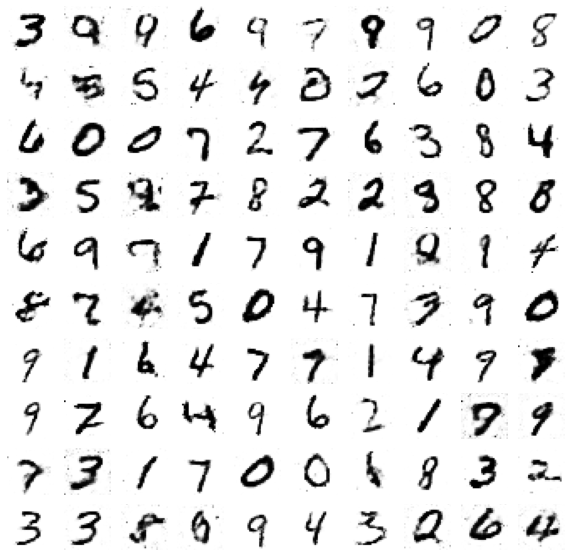

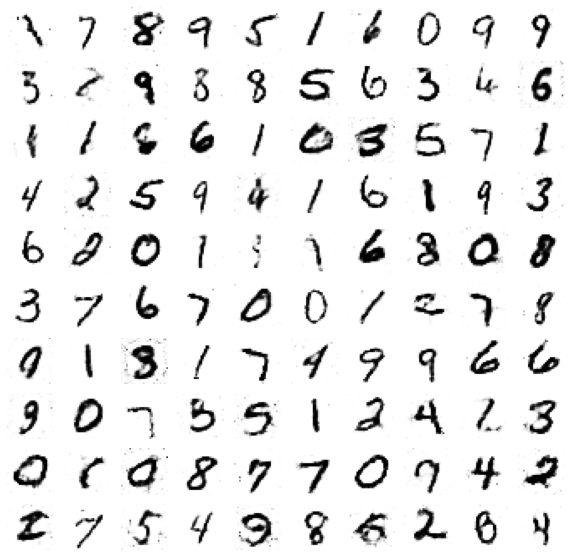

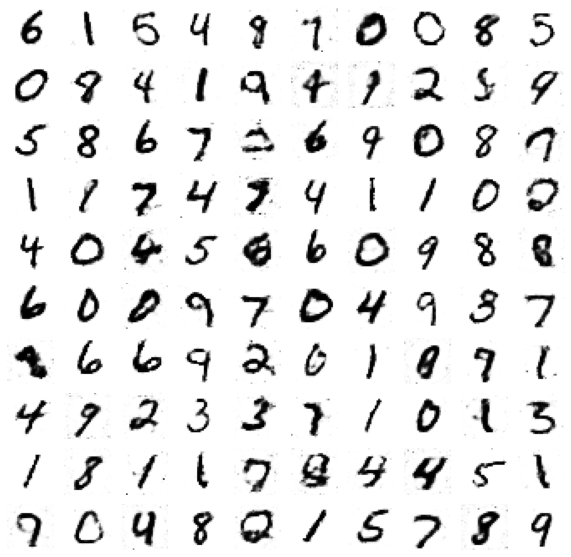

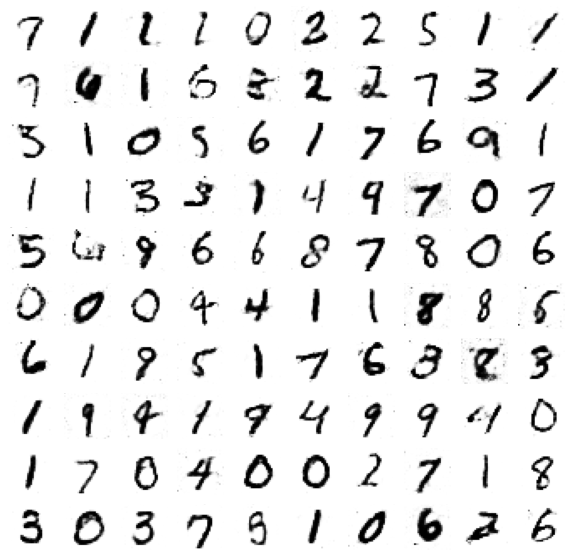

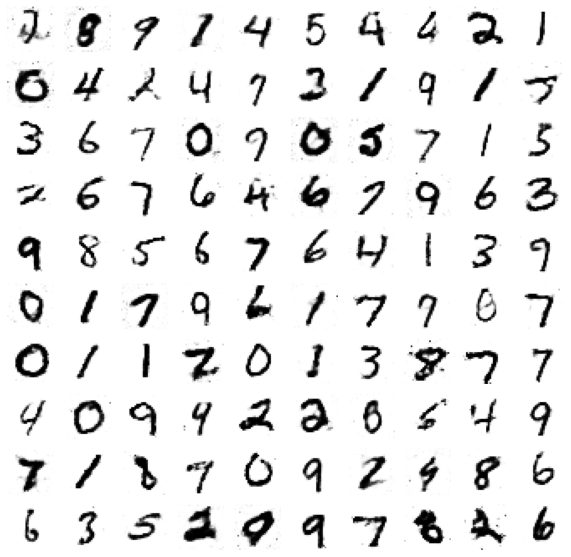

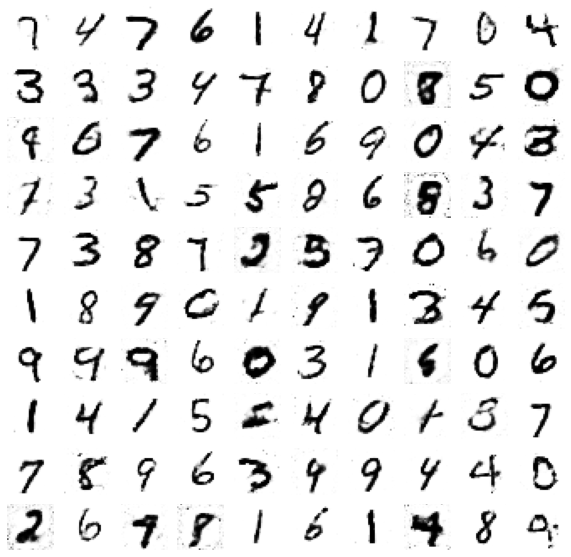

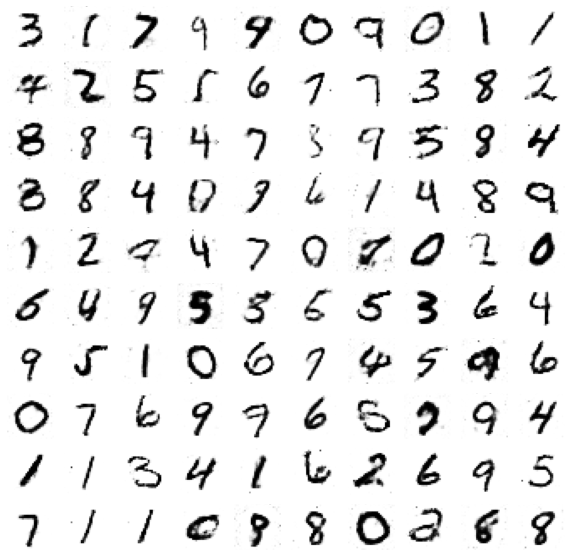

In [20]:
##### RUN THIS CODE FOR QUESTION 11 ####
from tqdm.notebook import trange

epochs = 200
batchsize = 128
plot_every = 10

for epoch_number in trange(epochs, desc='Epoch'):
    for _ in trange(X_train.shape[0] // batchsize, desc='Iteration'):
        train_gan(batchsize)
    if epoch_number % plot_every == 0:
        plot_generated_images()

 ### What happens as the GAN trains?


When GAN trains, we can see how pictures with bitumen becomes pictures with numbers from mnist set

Also the algorithm changes its prediction from epoch to epoch  to similar looking pictures, i.e. from 1 to 7 then to 4 than to 6 then to 8 then again to 1